# Project Two Code 

In [1]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from sklearn.linear_model import LogisticRegression
from transformers import pipeline

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Web Scraping NYT Articles Using NYT API 

In [2]:
import requests as req
import time
API_KEY='9kiWZKsGFtTkcTD4yYkyxWAKehiTKkzR' # your API key

In [3]:
import calendar

# Create an empty list to store articles
articles2 = []

# Loop through every month from Jan 2020 to Feb 2024
for year in range(2020, 2024):
    for month in range(1, 13):
        # Calculate the number of days in the current month
        num_days = calendar.monthrange(year, month)[1]

        # Construct the begin_date and end_date parameters for the query
        begin_date = f"{year:04d}-{month:02d}-01"
        end_date = f"{year:04d}-{month:02d}-{num_days:02d}"

        # Loop through 5 pages (max 10 results per page, hence 50 articles)
        for i in range(5):
            # Sleep to avoid exceeding the API rate limit
            time.sleep(10)
            try:
                # Construct the URL
                url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q=artificial+intelligence&api-key={API_KEY}&sort=relevance&begin_date={begin_date}&end_date={end_date}&page={i+1}'

                # Make the request and get the response
                response = req.get(url).json()
                # Extract relevant information from the response and append to articles list
                docs = response['response']['docs']
                for doc in docs:
                    filteredDoc = {}
                    filteredDoc['title'] = doc['headline']['main']
                    filteredDoc['abstract'] = doc['abstract']
                    filteredDoc['paragraph'] = doc['lead_paragraph']
                    filteredDoc['date'] = f"{year}-{month:02d}"
                    articles2.append(filteredDoc)
                
                
            except KeyError as e:
                print(f"No response while processing page {i+1} for {begin_date} - {end_date}: {e}")


No response while processing page 3 for 2020-02-01 - 2020-02-29: 'response'
No response while processing page 4 for 2020-04-01 - 2020-04-30: 'response'
No response while processing page 5 for 2020-07-01 - 2020-07-31: 'response'
No response while processing page 1 for 2020-11-01 - 2020-11-30: 'response'
No response while processing page 2 for 2021-01-01 - 2021-01-31: 'response'
No response while processing page 3 for 2021-04-01 - 2021-04-30: 'response'
No response while processing page 4 for 2021-06-01 - 2021-06-30: 'response'
No response while processing page 5 for 2021-09-01 - 2021-09-30: 'response'
No response while processing page 1 for 2022-01-01 - 2022-01-31: 'response'
No response while processing page 2 for 2022-03-01 - 2022-03-31: 'response'
No response while processing page 3 for 2022-06-01 - 2022-06-30: 'response'
No response while processing page 4 for 2022-08-01 - 2022-08-31: 'response'
No response while processing page 5 for 2022-11-01 - 2022-11-30: 'response'
No response 

In [4]:
nyt_ai2 = pd.DataFrame(data=articles2)

In [5]:
nyt_ai2.shape

(1370, 4)

#### Note: 1370 articles in total means an average of ~28-29 articles scraped per month 

In [7]:
nyt_ai2.to_csv('r2_scraped_nyt.csv')

## Text Upload

In [2]:
nyt_data = pd.read_csv('r2_scraped_nyt.csv')

In [3]:
nyt_data.drop(columns=['Unnamed: 0'])

,title,abstract,paragraph,date
0,Soon a Robot Will Be Writing This Headline,"In “A World Without Work,” the economist Danie...","A WORLD WITHOUT WORK Technology, Automation, a...",2020-01
1,A.I. Comes to the Operating Room,Images made by lasers and read by computers ca...,Brain surgeons are bringing artificial intelli...,2020-01
2,Confessions of a Dating Profile,"My boss’s demands were very, very persuasive, ...","My boss’s demands were very, very persuasive, ...",2020-01
3,"Lesson of the Day: ‘The Machines Are Learning,...","In this lesson, students will learn about how ...","Featured Article: “The Machines Are Learning, ...",2020-01
4,Facebook Says It Will Ban ‘Deepfakes’,The company said it would remove videos altere...,WASHINGTON — Facebook says it will ban videos ...,2020-01
...,...,...,...,...
1365,Cities Foster Serendipity. But Can They Do It ...,Revisiting a theory about chance collisions an...,There is a thing that happens in cities — that...,2023-10
1366,Allied Spy Chiefs Warn of Chinese Espionage Ta...,F.B.I. officials say more than half of Chinese...,The United States and its allies vowed this we...,2023-10
1367,Researchers Say Guardrails Built Around A.I. S...,OpenAI now lets outsiders tweak what its chatb...,Before it released the A.I. chatbot ChatGPT la...,2023-10
1368,An Industry Insider Drives an Open Alternative...,"The nonprofit Allen Institute for AI, led by a...",Ali Farhadi is no tech rebel.,2023-10


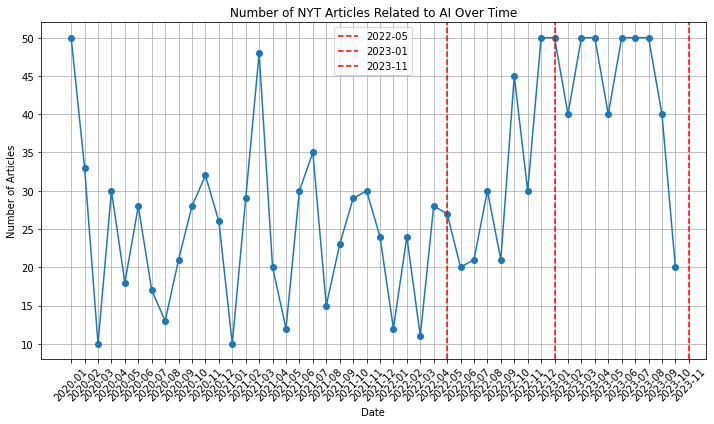

In [73]:
# Count the number of articles for each date
article_counts_by_date = nyt_data['date'].value_counts().sort_index()

# Plot the number of articles over time
plt.figure(figsize=(10, 6))
plt.plot(article_counts_by_date.index, article_counts_by_date.values, marker='o', linestyle='-')
plt.title('Number of NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at the start, peak and end of tech layoffs
plt.axvline(x='2022-05', color='r', linestyle='--', label='2022-05')
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')
plt.legend()
plt.show()

In [66]:
layoffs_data = pd.read_csv('layoffs_data(3).csv')

In [67]:
layoffs_data.head()

,Company,Location_HQ,Industry,Percentage,Date,Source,Funds_Raised,Stage,Date_Added,Country,Laid_Off_Count,List_of_Employees_Laid_Off
0,Fisker,Los Angeles,Transportation,0.15,2024-02-29,https://techcrunch.com/2024/02/29/fisker-layoffs-cash-going-concern-dealerships/,1700.0,Post-IPO,2024-02-29 23:35:20,United States,NaN,Unknown
1,Electronic Arts,SF Bay Area,Consumer,0.05,2024-02-28,https://www.cnbc.com/2024/02/28/ea-layoffs-company-to-cut-5percent-of-workforce-or-about-670-employees.html,2.0,Post-IPO,2024-02-29 00:45:00,United States,670.0,Unknown
2,Vacasa,Portland,Travel,0.05,2024-02-28,https://www.oregonlive.com/business/2024/02/portland-based-vacasa-will-lay-off-another-320-new-year-is-off-to-a-difficult-start.html,834.0,Post-IPO,2024-02-29 17:22:37,United States,320.0,Unknown
3,Treasury Prime,SF Bay Area,Finance,0.40,2024-02-28,https://www.bankingdive.com/news/treasury-prime-lay-off-40-50-employees-marketing-liaison-direct-fintech-partner-chris-dean/708770/,71.0,Series C,2024-02-29 00:48:03,United States,40.0,Unknown
4,Motional,Boston,Transportation,0.05,2024-02-28,https://techcrunch.com/2024/02/28/hyundai-backed-autonomous-company-motional-cuts-5-of-workforce/,NaN,Unknown,2024-02-28 18:50:58,United States,NaN,Unknown


In [68]:
# Convert 'date' column to datetime
layoffs_data['Date'] = pd.to_datetime(layoffs_data['Date'])

# Convert 'date' column to 'YYYY-MM' format
layoffs_data['Date'] = layoffs_data['Date'].dt.strftime('%Y-%m')

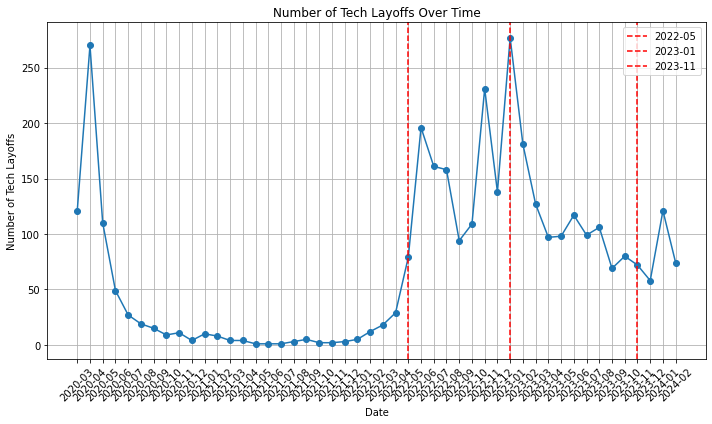

In [72]:
# Count the number of layoffs for each date
layoffs_counts_by_date = layoffs_data['Date'].value_counts().sort_index()
# Plot the number of layoffs over time
plt.figure(figsize=(10, 6))
plt.plot(layoffs_counts_by_date.index, layoffs_counts_by_date.values, marker='o', linestyle='-')
plt.title('Number of Tech Layoffs Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tech Layoffs')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2022-05', color='r', linestyle='--', label='2022-05')
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')
plt.legend()
plt.show()

## Sentiment Analysis Using Default DistilBERT Model

In [4]:
# Initiate a pipeline with the default sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis")

# Convert paragraphs to strings
nyt_data['abstract'] = nyt_data['abstract'].astype(str)

# Function to calculate sentiment score
def calculate_sentiment_score(paragraph):
    # Perform sentiment analysis on the paragraph
    sentiment = sentiment_pipeline(paragraph)[0]
    
    # If sentiment is negative, return -1 * score
    if sentiment['label'] == 'NEGATIVE':
        return -1 * sentiment['score']
    # If sentiment is positive, return +1 * score
    elif sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    else:
        return None

# Apply the function to each row and create a new column 'sentiment_score'
nyt_data['distilbert_sentiment_score'] = nyt_data['abstract'].apply(calculate_sentiment_score)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


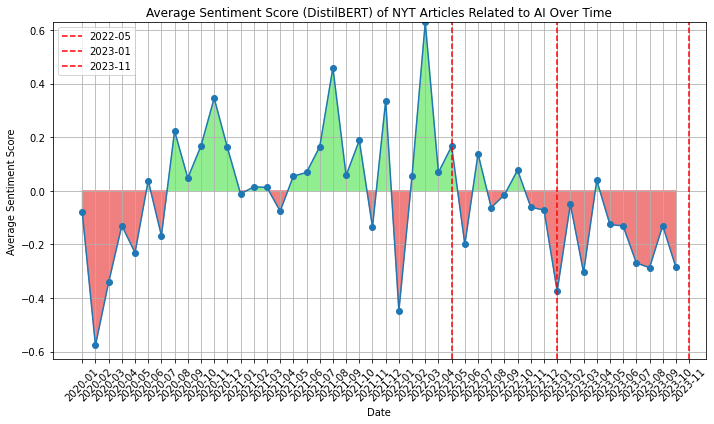

In [5]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = nyt_data.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
# Plot above zero values with green background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values >= 0, color='lightgreen', interpolate=True)

# Plot below zero values with red background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values <= 0, color='lightcoral', interpolate=True)

plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2022-05', color='r', linestyle='--', label='2022-05')
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')
plt.legend()

# Set y-axis limit to include 0 and center the graph at y=0
max_abs_score = max(abs(average_sentiment_by_date.min()), abs(average_sentiment_by_date.max()))
plt.ylim(-max_abs_score, max_abs_score)

plt.show() 

In [5]:
# Generate a dummy variable for positive/ negative 
nyt_data['distilbert_sentiment_dummy'] = nyt_data['distilbert_sentiment_score'].apply(lambda x: 1 if x > 0 else 0)

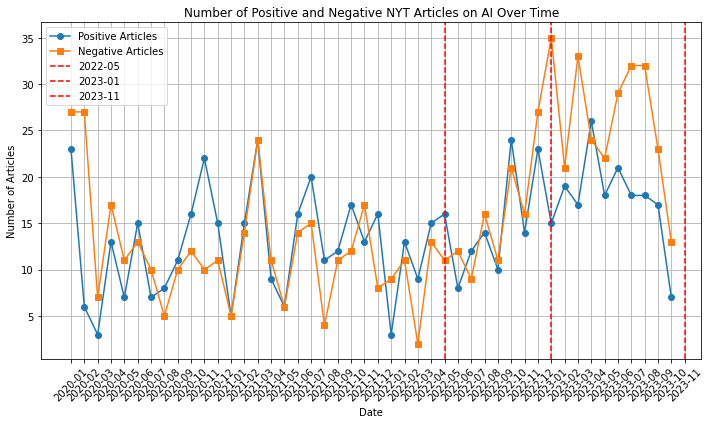

In [7]:
# Graph number of positive articles over time AND number of negative articles over time (two lines)
positive_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 1].groupby('date').size()
negative_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 0].groupby('date').size()

plt.figure(figsize=(10, 6))
plt.plot(positive_articles.index, positive_articles.values, label='Positive Articles', marker='o')
plt.plot(negative_articles.index, negative_articles.values, label='Negative Articles', marker='s')

plt.axvline(x='2022-05', color='r', linestyle='--', label='2022-05')
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')

plt.title('Number of Positive and Negative NYT Articles on AI Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Breaking down sentiment paths by articles that mentioned certain topics

#### Abstract Cleaning

In [6]:
import re
# create an empty list for clean paragraphs 
cleanabstract=[]
# for each rows in the df 
for i in range(len(nyt_data)):
    # replace unwanted characters 
    para=str(nyt_data['abstract'].iloc[i])
    para=para.replace('\r',' ')
    para=para.replace('\n',' ')
    para=para.replace('. ',' ')
    para=para.replace(', ',' ')
    # remove special characters
    para=re.sub('[^A-Za-z]+', ' ', para)
    # lowercase 
    cleanabstract.append(para.lower())
nyt_data['clean abstract']= cleanabstract

In [45]:
# Define employment-related keywords
employment_keywords = ['employment', 'jobs', 'job', 'occupation', 'work', 'trade', 'profession', 'occupations', 'professions', 'unemployment', 'layoffs']

# Function to check if paragraph contains employment-related keywords
def contains_employment_keywords(paragraph):
    for keyword in employment_keywords:
        if keyword in paragraph:
            return 1
    return 0

# Create dummy variable indicating whether employment-related keywords are mentioned
nyt_data['mentions_employment'] = nyt_data['clean abstract'].apply(contains_employment_keywords)


In [46]:
employment_mentions_nyt = nyt_data[nyt_data['mentions_employment'] == 1]


In [47]:
employment_mentions_nyt.shape

(147, 11)

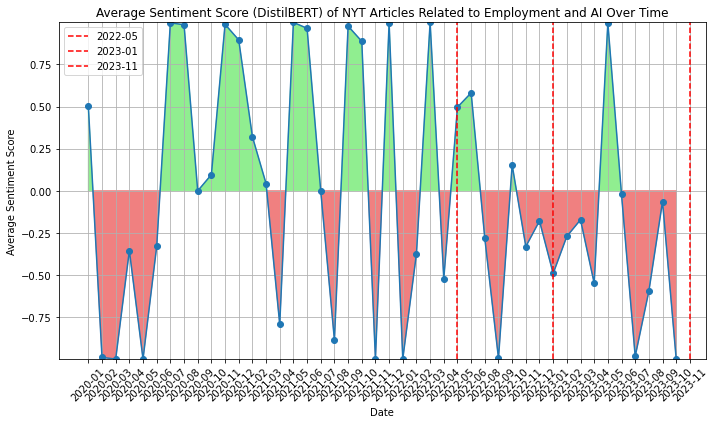

In [48]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = employment_mentions_nyt.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))

# Plot above zero values with green background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values >= 0, color='lightgreen', interpolate=True)

# Plot below zero values with red background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values <= 0, color='lightcoral', interpolate=True)

# Plot the line
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')

plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to Employment and AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2022-05', color='r', linestyle='--', label='2022-05')
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')
plt.legend()

# Set y-axis limit to include 0 and center the graph at y=0
max_abs_score = max(abs(average_sentiment_by_date.min()), abs(average_sentiment_by_date.max()))
plt.ylim(-max_abs_score, max_abs_score)

plt.show()

In [49]:
no_employment_mentions_nyt = nyt_data[nyt_data['mentions_employment'] == 0]

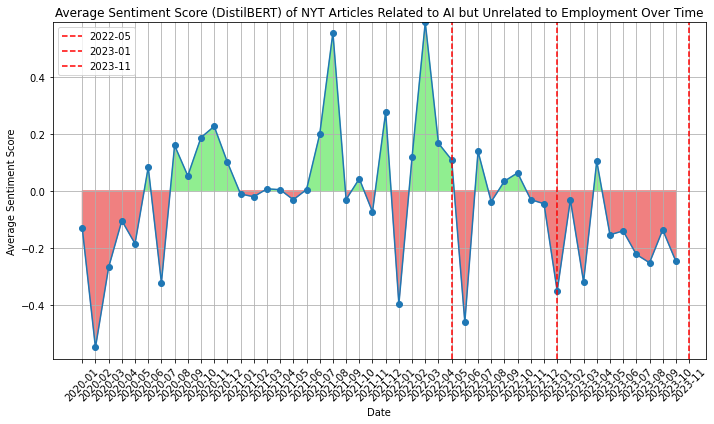

In [50]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = no_employment_mentions_nyt.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))

# Plot above zero values with green background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values >= 0, color='lightgreen', interpolate=True)

# Plot below zero values with red background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values <= 0, color='lightcoral', interpolate=True)

# Plot the line
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')

plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to AI but Unrelated to Employment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2022-05', color='r', linestyle='--', label='2022-05')
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')
plt.legend()

# Set y-axis limit to include 0 and center the graph at y=0
max_abs_score = max(abs(average_sentiment_by_date.min()), abs(average_sentiment_by_date.max()))
plt.ylim(-max_abs_score, max_abs_score)

plt.show()

In [14]:
chatgpt_keywords = ['chatgpt', 'gpt', 'openai', 'gpt-3','altman', 'sam altman', 'large language model', 'generative ai', 'chatbot']

# Function to check if paragraph contains employment-related keywords
def contains_chatgpt_keywords(paragraph):
    for keyword in chatgpt_keywords:
        if keyword in paragraph:
            return 1
    return 0

# Create dummy variable indicating whether employment-related keywords are mentioned
nyt_data['mentions_gpt'] = nyt_data['clean abstract'].apply(contains_chatgpt_keywords)

In [15]:
gpt_mentions_nyt = nyt_data[nyt_data['mentions_gpt'] == 1]

In [16]:
gpt_mentions_nyt.shape

(89, 10)

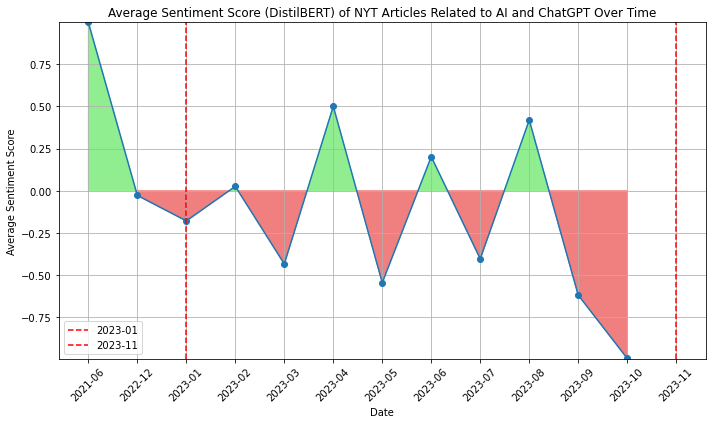

In [18]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = gpt_mentions_nyt.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))

# Plot above zero values with green background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values >= 0, color='lightgreen', interpolate=True)

# Plot below zero values with red background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values <= 0, color='lightcoral', interpolate=True)

# Plot the line
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')

plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to AI and ChatGPT Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')
plt.legend()

# Set y-axis limit to include 0 and center the graph at y=0
max_abs_score = max(abs(average_sentiment_by_date.min()), abs(average_sentiment_by_date.max()))
plt.ylim(-max_abs_score, max_abs_score)

plt.show()

In [19]:
gpt_mentions_nyt_1023 = gpt_mentions_nyt[gpt_mentions_nyt['date'] == '2023-10']

In [20]:
gpt_mentions_nyt_1023.head()

,Unnamed: 0.1,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,distilbert_sentiment_dummy,clean abstract,mentions_gpt
1367,1367,1367,Researchers Say Guardrails Built Around A.I. Systems Are Not So Sturdy,OpenAI now lets outsiders tweak what its chatbot does. A new paper says that can lead to trouble.,"Before it released the A.I. chatbot ChatGPT last year, the San Francisco start-up OpenAI added digital guardrails meant to prevent its system from doing things like generating hate speech and disinformation. Google did something similar with its Bard chatbot.",2023-10,-0.992918,0,openai now lets outsiders tweak what its chatbot does a new paper says that can lead to trouble,1


In [36]:
no_gpt_mentions_nyt = nyt_data[nyt_data['mentions_gpt'] == 0]

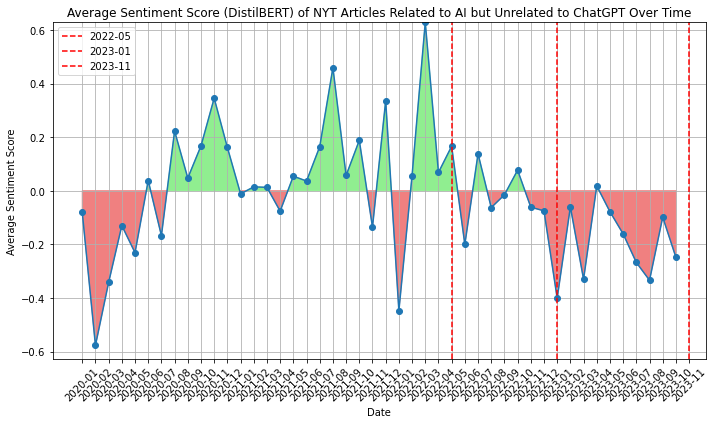

In [37]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = no_gpt_mentions_nyt.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))

# Plot above zero values with green background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values >= 0, color='lightgreen', interpolate=True)

# Plot below zero values with red background
plt.fill_between(average_sentiment_by_date.index, average_sentiment_by_date.values, 0, where=average_sentiment_by_date.values <= 0, color='lightcoral', interpolate=True)

# Plot the line
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')

plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to AI but Unrelated to ChatGPT Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2022-05', color='r', linestyle='--', label='2022-05')
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-11', color='r', linestyle='--', label='2023-11')
plt.legend()

# Set y-axis limit to include 0 and center the graph at y=0
max_abs_score = max(abs(average_sentiment_by_date.min()), abs(average_sentiment_by_date.max()))
plt.ylim(-max_abs_score, max_abs_score)

plt.show()

In [21]:
# to save progress
nyt_data.to_csv('nyt_with_distilbert.csv')

## Article Deep Dive

In [12]:
pd.set_option('display.max_colwidth', None)

In [46]:
# exploring negative articles
sorted_data = nyt_data.sort_values(by='distilbert_sentiment_score', ascending=True)
sorted_data.head()

,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,distilbert_sentiment_dummy,clean abstract,mentions_employment,clean abstract no employment
615,615,Neil Young Says ‘No More’ to Spotify,"Without real streaming alternatives around, a musician’s move to shame Spotify is doomed to failure.","It’s no surprise to me that the singer-songwriter Neil Young followed through on his threat to pull his music from Spotify in protest of the Covid misinformation spouted by that streaming service’s brightest star, Joe Rogan.",2022-01,-0.999796,0,without real streaming alternatives around a musician s move to shame spotify is doomed to failure,0,without real streaming alternatives around a musician s move to shame spotify is doomed to failure
883,883,"May I Speak to a Human, Please?",Younger investors who are navigating market volatility and trying to save for retirement are finding that roboadvisers lack the personal touch.,"Breana Jones started investing in 2014, building up her retirement savings and putting aside money to buy a house. “I have youth on my side,” said Ms. Jones, a 32-year-old Los Angeles resident and project manager. “I’ve tried to remain hands-off and use my age to my advantage.”",2022-12,-0.999793,0,younger investors who are navigating market volatility and trying to save for retirement are finding that roboadvisers lack the personal touch,0,younger investors who are navigating market volatility and trying to save for retirement are finding that roboadvisers lack the personal touch
1239,1239,Watch Out for the Fake Tom Cruise,Hollywood is about to get even more phony!,"WASHINGTON — In the 2002 movie “Simone,” Al Pacino plays a director whose star, played by Winona Ryder, walks out on him after saying her trailer on set isn’t grand enough.",2023-07,-0.999791,0,hollywood is about to get even more phony,0,hollywood is about to get even more phony
1058,1058,"How Siri, Alexa and Google Assistant Lost the A.I. Race","The virtual assistants had more than a decade to become indispensable. But they were hampered by clunky design and miscalculations, leaving room for chatbots to rise.","On a rainy Tuesday in San Francisco, Apple executives took the stage in a crowded auditorium to unveil the fifth-generation iPhone. The phone, which looked identical to the previous version, had a new feature that the audience was soon buzzing about: Siri, a virtual assistant.",2023-03,-0.999776,0,the virtual assistants had more than a decade to become indispensable but they were hampered by clunky design and miscalculations leaving room for chatbots to rise,0,the virtual assistants had more than a decade to become indispensable but they were hampered by clunky design and miscalculations leaving room for chatbots to rise
1114,1114,Snap’s Sales Fall for First Time as a Public Company,"As other tech companies returned to growth, Snap continued to struggle with advertising sales and lost money in the first quarter.","Snap, the parent company of Snapchat, reported on Thursday that its revenue had fallen for the first time since it went public as the app maker struggled to adjust to a difficult economic environment.",2023-04,-0.999771,0,as other tech companies returned to growth snap continued to struggle with advertising sales and lost money in the first quarter,0,as other tech companies returned to growth snap continued to struggle with advertising sales and lost money in the first quarter


In [47]:
# exploring positive articles
sorted_data = nyt_data.sort_values(by='distilbert_sentiment_score', ascending=False)
sorted_data.head()

,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,distilbert_sentiment_dummy,clean abstract,mentions_employment,clean abstract no employment
655,655,A Tour of Writing’s History Bounces From Script to Script,"In “The Greatest Invention,” Silvia Ferrara offers a dizzying and entertaining tour of written language.",THE GREATEST INVENTIONA History of the World in Nine Mysterious ScriptsBy Silvia Ferrara. Translated by Todd Portnowitz.,2022-03,0.999860,1,in the greatest invention silvia ferrara offers a dizzying and entertaining tour of written language,0,in the greatest invention silvia ferrara offers a dizzying and entertaining tour of written language
599,599,21 Things That Happened for the First Time in 2021,Surprising and serious events and trends noted for the first time ever this year.,"This article is part of a series called Turning Points, in which writers explore what critical moments from this year might mean for the year ahead. You can read more by visiting the Turning Points series page.",2021-12,0.999847,1,surprising and serious events and trends noted for the first time ever this year,0,surprising and serious events and trends noted for the first time ever this year
137,137,Transcending Space and Time Through Tape,Audio gems that bring a moment into focus.,"READER CALLOUT: Want relationship advice from Esther Perel? Submit a question about your personal relationships during the pandemic, and the therapist and author may answer it in a future episode of The Daily.",2020-05,0.999835,1,audio gems that bring a moment into focus,0,audio gems that bring a moment into focus
876,876,What Riding in a Self-Driving Tesla Tells Us About the Future of Autonomy,"We took a ride with Tesla’s experimental self-driving system. It was by turns intriguing, impressive and scary.","We took a ride with Tesla’s experimental self-driving system. It was by turns intriguing, impressive and scary.",2022-11,0.999833,1,we took a ride with tesla s experimental self driving system it was by turns intriguing impressive and scary,0,we took a ride with tesla s experimental self driving system it was by turns intriguing impressive and scary
1253,1253,Is A.I. the Greatest Technology Ever for Making Dumb Jokes?,"It may or may not alter the course of humanity, but at least the memes are fun.","It may or may not alter the course of humanity, but at least the memes are fun.",2023-07,0.999823,1,it may or may not alter the course of humanity but at least the memes are fun,0,it may or may not alter the course of humanity but at least the memes are fun


In [42]:
# exploring which negative articles popped up during peak layoff period 
# Filter the DataFrame for the date '2023-01'
filtered_data = nyt_data[nyt_data['date'] == '2023-01']

# Sort the filtered DataFrame by 'distilbert_sentiment_score' in descending order
sorted_data = filtered_data.sort_values(by='distilbert_sentiment_score', ascending=True)

sorted_data.head()

,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,distilbert_sentiment_dummy,clean abstract,mentions_employment,clean abstract no employment
976,976,Why Netflix Is Changing the Guard,Reed Hastings’s move to become executive chairman may be a sign that the streaming giant thinks the worst may be behind it.,"For 25 years, Reed Hastings was not only Netflix’s co-founder, but also its most visible cheerleader and advocate. Yesterday he announced that he would relinquish his co-C.E.O. title to a top deputy and become executive chairman.",2023-01,-0.999734,0,reed hastings s move to become executive chairman may be a sign that the streaming giant thinks the worst may be behind it,0,reed hastings s move to become executive chairman may be a sign that the streaming giant thinks the worst may be behind it
933,933,Elon Musk’s Appetite for Destruction,A wave of lawsuits argue that Tesla’s self-driving software is dangerously overhyped. What can its blind spots teach us about the company’s erratic C.E.O.?,"Early on, the software had the regrettable habit of hitting police cruisers. No one knew why, though Tesla’s engineers had some good guesses: Stationary objects and flashing lights seemed to trick the A.I. The car would be driving along normally, the computer well in control, and suddenly it would veer to the right or left and — smash — at least 10 times in just over three years.",2023-01,-0.999673,0,a wave of lawsuits argue that tesla s self driving software is dangerously overhyped what can its blind spots teach us about the company s erratic c e o,0,a wave of lawsuits argue that tesla s self driving software is dangerously overhyped what can its blind spots teach us about the company s erratic c e o
956,956,"Microsoft Revenue Up 2 Percent, but Profit Drops 12 Percent","The company, which announced plans to lay off 10,000 workers last week, had warned that was facing a significant slowdown in the growth of its sales.",Microsoft on Tuesday reported its slowest growth in six years and cautioned that a broader slump will continue as both consumers and businesses put the brakes on spending.,2023-01,-0.999522,0,the company which announced plans to lay off workers last week had warned that was facing a significant slowdown in the growth of its sales,1,the company which announced plans to lay off ers last week had warned that was facing a significant slowdown in the growth of its sales
978,978,Winter TV: 24 Shows to Keep an Eye On,That downturn in streaming content that you’ve been hearing about? Not here yet.,"There is a sea change coming to your TV screens, as shifting economics in the television and streaming video industries lead to a sudden decrease in the number of series competing for your limited attention and dollars. (Hold your applause.)",2023-01,-0.999496,0,that downturn in streaming content that you ve been hearing about not here yet,0,that downturn in streaming content that you ve been hearing about not here yet
949,949,Microsoft Services Back Online After Morning Outages,The widely used Microsoft Teams and Outlook email services were unavailable for thousands of users early Wednesday.,Microsoft restored access to its email and video conferencing tools on Wednesday after thousands of users were unable to connect to the services for hours.,2023-01,-0.999444,0,the widely used microsoft teams and outlook email services were unavailable for thousands of users early wednesday,0,the widely used microsoft teams and outlook email services were unavailable for thousands of users early wednesday


In [43]:
# Now for the most negative articles that are both AI and employment related 
# Filter the DataFrame for the date '2023-01' and where 'mentions_employment' is equal to 1
filtered_data = nyt_data[(nyt_data['date'] == '2023-01') & (nyt_data['mentions_employment'] == 1)]

# Sort the filtered DataFrame by 'distilbert_sentiment_score' in descending order
sorted_data = filtered_data.sort_values(by='distilbert_sentiment_score', ascending=True)

sorted_data.head()


,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,distilbert_sentiment_dummy,clean abstract,mentions_employment,clean abstract no employment
956,956,"Microsoft Revenue Up 2 Percent, but Profit Drops 12 Percent","The company, which announced plans to lay off 10,000 workers last week, had warned that was facing a significant slowdown in the growth of its sales.",Microsoft on Tuesday reported its slowest growth in six years and cautioned that a broader slump will continue as both consumers and businesses put the brakes on spending.,2023-01,-0.999522,0,the company which announced plans to lay off workers last week had warned that was facing a significant slowdown in the growth of its sales,1,the company which announced plans to lay off ers last week had warned that was facing a significant slowdown in the growth of its sales
951,951,"Microsoft to Lay Off 10,000 Workers as It Looks to Trim Costs","The job cuts, which amount to less than 5 percent of the company’s work force, are its largest in roughly eight years.",Microsoft on Wednesday became the latest addition to a growing list of big technology companies that have announced plans to lay off employees because of overhiring during the pandemic and worries about the economy.,2023-01,-0.995857,0,the job cuts which amount to less than percent of the company s work force are its largest in roughly eight years,1,the cuts which amount to less than percent of the company s force are its largest in roughly eight years
954,954,"Google Parent Alphabet to Cut 12,000 Jobs","The layoffs amount to about 6 percent of the global work force at the company, the latest tech giant to make cuts after a pandemic hiring spree.","Alphabet, the parent company of Google, said on Friday that it planned to cut 12,000 jobs, becoming the latest technology company to reduce its work force because of concerns about a broader economic slowdown, after a hiring spree during the pandemic.",2023-01,-0.995592,0,the layoffs amount to about percent of the global work force at the company the latest tech giant to make cuts after a pandemic hiring spree,1,the layoffs amount to about percent of the global force at the company the latest tech giant to make cuts after a pandemic hiring spree
966,966,The Crypto Collapse and the End of the Magical Thinking That Infected Capitalism,Dogecoin. WeWork. The Metaverse. It was an era of illusory and ridiculous promises.,"At a guest lecture at a military academy when the price of a single Bitcoin neared $60,000, I was asked, as finance professors often are, what I thought about cryptocurrencies. Rather than respond with my usual skepticism, I polled the students. More than half of attendees had traded cryptocurrencies, often financed by loans.",2023-01,-0.992881,0,dogecoin wework the metaverse it was an era of illusory and ridiculous promises,1,dogecoin we the metaverse it was an era of illusory and ridiculous promises
961,961,The Week in Business: Creeping Layoffs,Data shows that the U.S. economy has been largely resilient. The Fed may slow its rate increases. And the jobs report is expected to show solid gains.,"What began as a wave of ominous job cuts by technology companies is rippling through other industries, most recently media and retail. In the last week alone, layoffs, or reports of coming layoffs, have swept The Washington Post, Vox and Saks.com. Adding to the tens of thousands of unemployed tech workers, Spotify said on Monday that it was cutting 6 percent of its work force, or about 600 employees, and IBM announced on Wednesday that it would shed 3,900. Tech’s challenges may be somewhat particular to the sector — employers have largely pointed to overhiring during the pandemic as a reason for the recent cuts — but its upheaval can be an indicator of where the economy is heading. Yet even as layoffs appear to creep across the job market, unemployment claims overall remain low, and millions of jobs are open across the country.",2023-01,-0.731695,0,data 